# Example 7

In this example, we evolve a list of  binary systems (in the file [listBin.dat](listBin.dat)) to analyse the merging binary black holes (BBHs), found their formation channel
and run alternative models assuming a super Eddington accretion on BHs.

    - We show how to merge the output file with the CE information from the logfile
    - We show how to separate the CE and the stable mass transfer BBH formation channel
    - We show how to run alternative models changing the assumptions/models of the binary processes

- To compile SEVN use the [compile.sh](compile.sh) script
- To run  use [run.sh](run.sh)
- To run assuming super eddington accretion  and RLO accretion efficiency from Hurley+02 use: [run_sedd.sh](run_sedd.sh)
- To run assuming super eddington accretion  and RLO accretion efficiency from Hurley+02 and not tides use: [run_sedd_notides.sh](run_sedd_notides.sh)

Remember to set the proper SEVN path in the compile and run scripts

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

def read_CElog(logfile):
    """
    Get the CE entries in the SEVN logfile
    :@param logfile complete path the logfile
    :@return a pandas Dataframe with the following columns
        - name: SEVN unique name of the bianry
        - ID: SEVN unique ID of the binary
        - time: time at which the CE is triggered [Myr]
        - id0: id of the Star in the binary that is considered the primary in the CE (usually the more evolved one)
        - m0: mass of the primary at the onset of the CE [Msun]
        - mhe0: helium core mass of the primary at the onset of the CE [Msun]
        - mco0: carbon-oxygen core mass of the primary at the onset of the CE [Msun]
        - phase0: SEVN phase of the primary at the onset of the CE
        - remnant0: Remnant type of the primary at the onset of the CE
        - id1: id of the Star in the binary that is considered the secondary in the CE (usually the less evolved one)
        - m1: mass of the secondary at the onset of the CE [Msun]
        - mhe1: helium core mass of the secondary at the onset of the CE [Msun]
        - mco1: carbon-oxygen core mass of the secondary at the onset of the CE [Msun]
        - phase1: SEVN phase of the secondary at the onset of the CE
        - remnant1: Remnant type of the secondary at the onset of the CE
        - a: semi-major axis at the onset of the CE [Rsun]
        - e: eccentricity at the onset of the CE
        - coalesce: CE ejection flag, 0 means that the CE was succesfully ejectes, 1 indicates a failed CE ending with a coalescence 
    """
    
    mnum="[[+|-]?[0-9]+\.?[0-9]*e?[+|-]?[0-9]*|(?i)nan]" #Match any number and nan
    mID="[0-9]+" #match IDS
    mname="(?:[0-9|A-Za-z]*\_)?[0-9]*" #match SEVN names 
    mtype="[+|-]?\d+" #Match stellar phase/types
    
    stardata=f"({mtype}):({mnum}):({mnum}):({mnum}):({mtype}):({mtype})"
    matchexpre=f"B;({mname});({mID});CE;({mnum});{stardata}:{stardata}:({mnum}):({mnum}):({mtype})"
    
    with  open(logfile,"r") as fo:
        fr=fo.read()
        ca=re.findall(matchexpre,fr)
    
    ca=np.array(ca)
    dfa={"name":np.array(ca[:,0], dtype=int),
        "ID":np.array(ca[:,1], dtype=int)}
    
    caf=np.array(ca[:,2:], dtype=np.float64)
    
    name_list=("time","id0","m0","mhe0","mco0","phase0","remnant0","id1","m1","mhe1","mco1","phase1","remnant1",
              "a","e","coalesce")
    
    for j,name in enumerate(name_list):
        dfa[name]=caf[:,j]
    
    return pd.DataFrame.from_dict(dfa)



In [11]:
df=pd.read_csv("BHBHm.csv")
df=df[df.alpha==1]
df=df.sample(1000)
fo=open("listBin.dat","w")
for m0,m1,a,e,Z in df[["Mzams_0","Mzams_1","Semimajor_ini","Eccentricity_ini","Z"]].values:
    print(f"{m0} {Z} 0.0 rapid zams {m1} {Z} 0.0 rapid zams {a} {e} end end {np.random.randint(1,int(1e15))}",file=fo)
fo.close()

Total number of merging BBHs: 932
Number of merging BBHs thorugh the CE channel: 603
Number of merging BBHs thorugh the SMT channel: 329


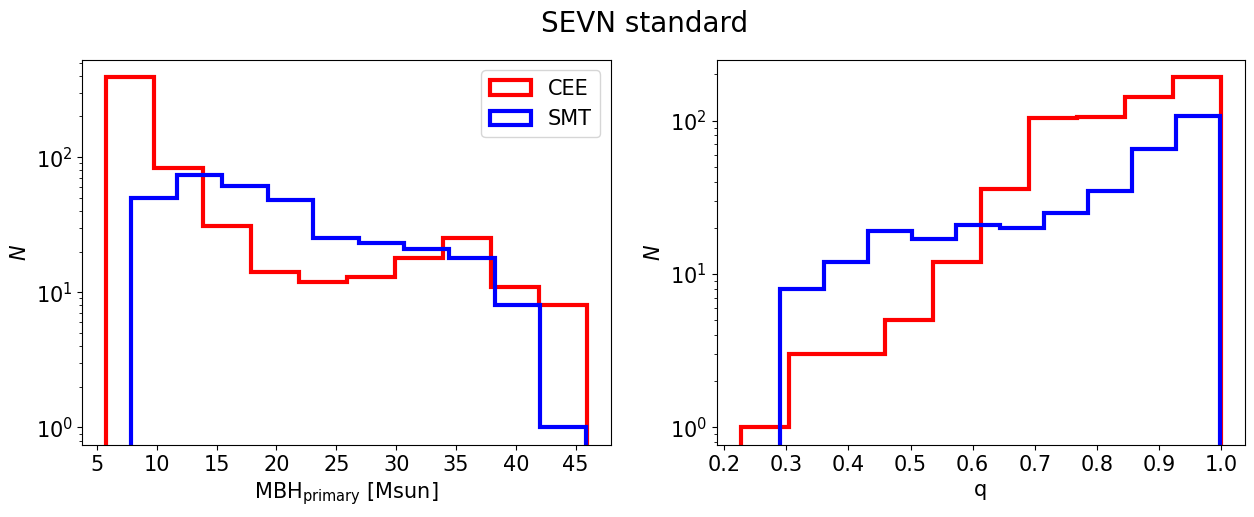

In [124]:
df=pd.read_csv("sevn_output/output_0.csv")
df["tdelay"]=df.GWtime+df.BWorldtime
df=df[ (df.tdelay<14000) & (df.RemnantType_0==6) & (df.RemnantType_1==6)]

logCE=read_CElog("sevn_output/logfile_0.dat")
counts=logCE.groupby(["name"]).size()
countCE=pd.DataFrame({'nCE' : counts}).reset_index()
dffCE=df.merge(countCE, on=["name"], how="left")
dffCE['nCE'] = dffCE['nCE'].fillna(0)

idxCE=dffCE.nCE>0
idxSMT=dffCE.nCE==0

print(f"Total number of merging BBHs: {len(df)}\n"
      f"Number of merging BBHs thorugh the CE channel: {np.sum(idxCE)}\n"
      f"Number of merging BBHs thorugh the SMT channel: {np.sum(idxSMT)}")

dffCE.to_csv("BBH_fiducial.csv",index=False)

Mprimary=np.where(dffCE.Mass_0>dffCE.Mass_1,dffCE.Mass_0,dffCE.Mass_1)
Msecondary=np.where(dffCE.Mass_0>dffCE.Mass_1,dffCE.Mass_1,dffCE.Mass_0)

fig=plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
plt.sca(ax)
plt.hist(Mprimary[idxCE],histtype="step",lw=3,bins=10,label="CEE",color="red")
plt.hist(Mprimary[idxSMT],histtype="step",lw=3,bins=10,label="SMT",color="blue")
plt.xlabel("MBH$_\mathrm{primary}$ [Msun]",fontsize=15)
plt.ylabel("$N$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.yscale("log")


ax=plt.subplot(1,2,2)
plt.sca(ax)
plt.hist(Msecondary[idxCE]/Mprimary[idxCE],histtype="step",lw=3,bins=10,color="red")
plt.hist(Msecondary[idxSMT]/Mprimary[idxSMT],histtype="step",lw=3,bins=10,color="blue")
plt.xlabel("q",fontsize=15)
plt.ylabel("$N$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")

fig.suptitle("SEVN standard", fontsize=20)

plt.show()

Total number of merging BBHs: 360
Number of merging BBHs thorugh the CE channel: 339
Number of merging BBHs thorugh the SMT channel: 21


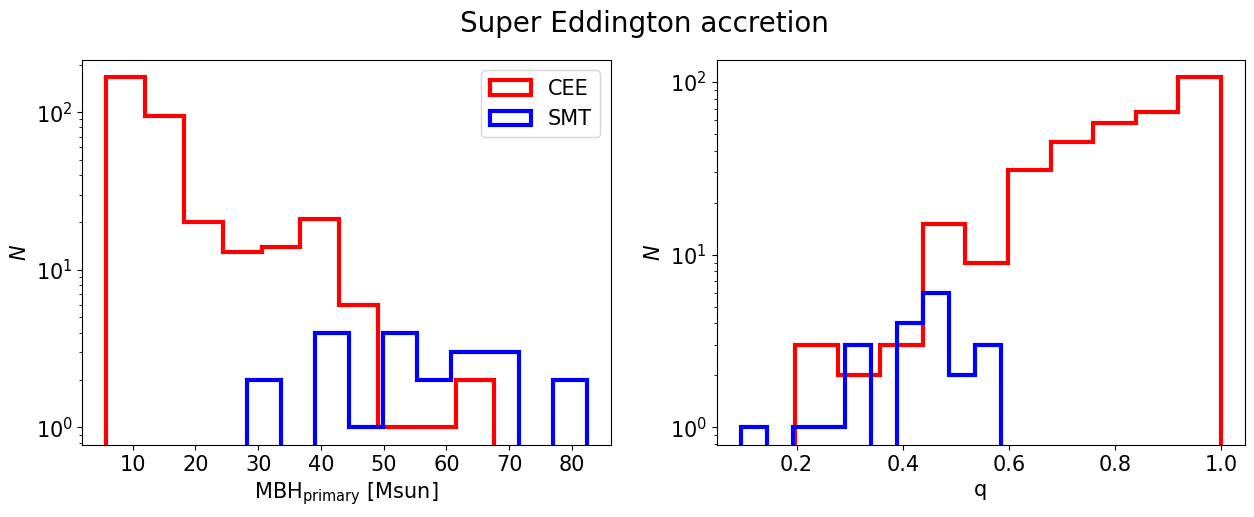

In [123]:
df=pd.read_csv("sevn_output_sedd/output_0.csv")
logCE=read_CElog("sevn_output_sedd/logfile_0.dat")

df["tdelay"]=df.GWtime+df.BWorldtime
df=df[ (df.tdelay<14000) & (df.RemnantType_0==6) & (df.RemnantType_1==6)]

counts=logCE.groupby(["name"]).size()
countCE=pd.DataFrame({'nCE' : counts}).reset_index()
dffCE=df.merge(countCE, on=["name"], how="left")
dffCE['nCE'] = dffCE['nCE'].fillna(0)

idxCE=dffCE.nCE>0
idxSMT=dffCE.nCE==0

dffCE.to_csv("BBH_sedd.csv",index=False)

print(f"Total number of merging BBHs: {len(df)}\n"
      f"Number of merging BBHs thorugh the CE channel: {np.sum(idxCE)}\n"
      f"Number of merging BBHs thorugh the SMT channel: {np.sum(idxSMT)}")

Mprimary=np.where(dffCE.Mass_0>dffCE.Mass_1,dffCE.Mass_0,dffCE.Mass_1)
Msecondary=np.where(dffCE.Mass_0>dffCE.Mass_1,dffCE.Mass_1,dffCE.Mass_0)

fig=plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
plt.sca(ax)
plt.hist(Mprimary[idxCE],histtype="step",lw=3,bins=10,label="CEE",color="red")
plt.hist(Mprimary[idxSMT],histtype="step",lw=3,bins=10,label="SMT",color="blue")
plt.xlabel("MBH$_\mathrm{primary}$ [Msun]",fontsize=15)
plt.ylabel("$N$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.yscale("log")


ax=plt.subplot(1,2,2)
plt.sca(ax)
plt.hist(Msecondary[idxCE]/Mprimary[idxCE],histtype="step",lw=3,bins=10,color="red")
plt.hist(Msecondary[idxSMT]/Mprimary[idxSMT],histtype="step",lw=3,bins=10,color="blue")
plt.xlabel("q",fontsize=15)
plt.ylabel("$N$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")


fig.suptitle("Super Eddington accretion", fontsize=20)

plt.show()

Total number of merging BBHs: 388
Number of merging BBHs thorugh the CE channel: 318
Number of merging BBHs thorugh the SMT channel: 70


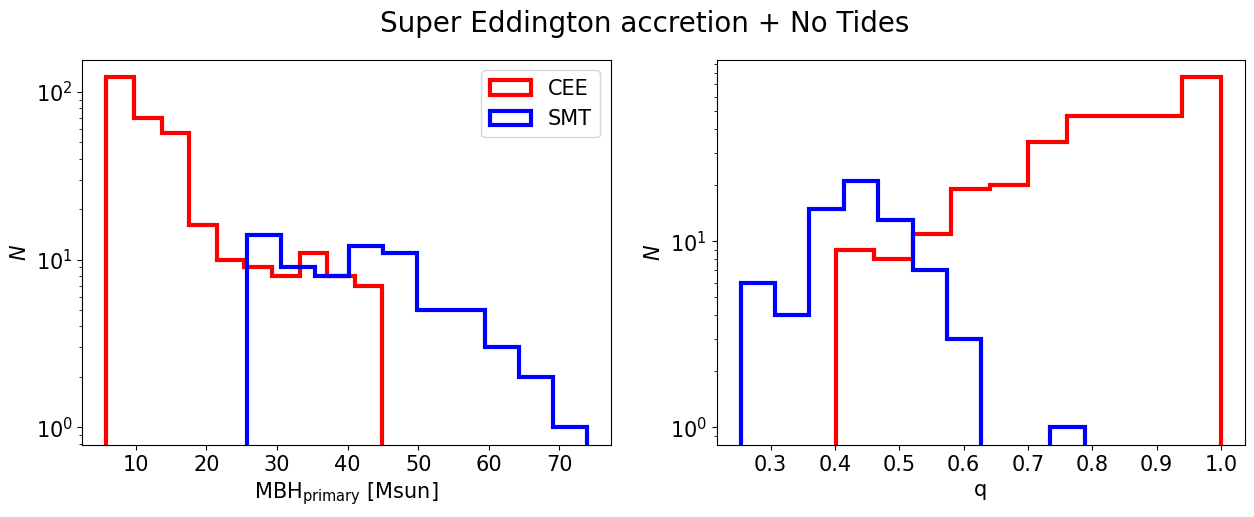

In [122]:
#What happens if we remove the tides


df=pd.read_csv("sevn_output_sedd_notides/output_0.csv")
logCE=read_CElog("sevn_output_sedd_notides/logfile_0.dat")

df["tdelay"]=df.GWtime+df.BWorldtime
df=df[ (df.tdelay<14000) & (df.RemnantType_0==6) & (df.RemnantType_1==6)]

counts=logCE.groupby(["name"]).size()
countCE=pd.DataFrame({'nCE' : counts}).reset_index()
dffCE=df.merge(countCE, on=["name"], how="left")
dffCE['nCE'] = dffCE['nCE'].fillna(0)

idxCE=dffCE.nCE>0
idxSMT=dffCE.nCE==0

dffCE.to_csv("BBH_sedd.csv",index=False)

print(f"Total number of merging BBHs: {len(df)}\n"
      f"Number of merging BBHs thorugh the CE channel: {np.sum(idxCE)}\n"
      f"Number of merging BBHs thorugh the SMT channel: {np.sum(idxSMT)}")

Mprimary=np.where(dffCE.Mass_0>dffCE.Mass_1,dffCE.Mass_0,dffCE.Mass_1)
Msecondary=np.where(dffCE.Mass_0>dffCE.Mass_1,dffCE.Mass_1,dffCE.Mass_0)

fig=plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
plt.sca(ax)
plt.hist(Mprimary[idxCE],histtype="step",lw=3,bins=10,label="CEE",color="red")
plt.hist(Mprimary[idxSMT],histtype="step",lw=3,bins=10,label="SMT",color="blue")
plt.xlabel("MBH$_\mathrm{primary}$ [Msun]",fontsize=15)
plt.ylabel("$N$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.yscale("log")


ax=plt.subplot(1,2,2)
plt.sca(ax)
plt.hist(Msecondary[idxCE]/Mprimary[idxCE],histtype="step",lw=3,bins=10,color="red")
plt.hist(Msecondary[idxSMT]/Mprimary[idxSMT],histtype="step",lw=3,bins=10,color="blue")
plt.xlabel("q",fontsize=15)
plt.ylabel("$N$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")

fig.suptitle("Super Eddington accretion + No Tides", fontsize=20)

plt.show()

